In [1]:
import numpy as np
from numpy import linalg
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import itertools
# Copyright 2021 Google Inc. All Rights Reserved.
#
#Licensed under the Apache License, Version 2.0 (the "License");
#you may not use this file except in compliance with the License.
#You may obtain a copy of the License at

   # http://www.apache.org/licenses/LICENSE-2.0

#Unless required by applicable law or agreed to in writing, software
#distributed under the License is distributed on an "AS IS" BASIS,
#WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#See the License for the specific language governing permissions and
#limitations under the License.
#==============================================================================
#

class Data(object):
    #Dataset1: Generating linearly seperable dataset
    def generate_linearlydataset_linear(self,seed=1):
        np.random.seed(seed)
        mean1 = np.array([0,3])
        mean2 = np.array([3,0])
        return mean1, mean2
    
    def generate_helperdataset(self,mean1, cov, mean2):
        X1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def generate_linearly_separable_data(self,seed=1):
        mean1, mean2 = self.generate_linearlydataset_linear()
        cov = np.array([[0.4, 0.7], [0.7, 0.4]])
        return self.generate_helperdataset(mean1,cov,mean2)

    def gen_non_lin_separable_data(self,seed=1):
        np.random.seed(seed)
        mean1 = [-5, 7]
        mean2 = [7, -5]
        mean3 = [11, -9]
        mean4 = [-9, 11]
        cov = [[2.1, 0.9], [0.9, 2.1]]
        X1 = np.random.multivariate_normal(mean1, cov, 50)
        X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 50)
        X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def gen_lin_separable_overlap_data(self,seed=1):
        np.random.seed(seed)
        mean1 = np.array([-3, 7])
        mean2 = np.array([7, -3])
        cov = np.array([[3.5, 2.7], [2.7, 3.5]])
        return self.generate_helperdataset(mean1,cov,mean2)

    def split_data(X1, y1, X2, y2,percent):
        dataset_size = len(X1)
        threshold = int(dataset_size*percent);

        # Training data: binary classifier X1, X2
        X1_train = X1[:threshold]
        y1_train = y1[:threshold]
        X2_train = X2[:threshold]
        y2_train = y2[:threshold]

        #stack datasets
        X_train = np.vstack((X1_train, X2_train))
        y_train = np.hstack((y1_train, y2_train))

        # Test data:
        X1_test = X1[threshold:]
        y1_test = y1[threshold:]
        X2_test = X2[threshold:]
        y2_test = y2[threshold:]

        X_test = np.vstack((X1_test, X2_test))
        y_test = np.hstack((y1_test, y2_test))

        return X_train, y_train, X_test, y_test


In [2]:
# Collection of usual kernels
class Kernel(object):
    @staticmethod
    def linear():
        def f(x, y):
            return np.inner(x, y)
        return f

    @staticmethod
    def rbf(gamma):
        def f(x, y):
            exponent = - gamma * np.linalg.norm(x-y) ** 2
            return np.exp(exponent)
        return f

    @staticmethod
    def quadratic(offset=0.0, gamma=1.0):
        def f(x, y):
            return (gamma * (offset + np.dot(x, y)) ) ** 2
        return f

In [3]:

class SVM(object):
    def __init__(self, kernel,kernel_type = 'linear', C=1.0,gamma=0.01, degree=3, max_iter=1000, tol=0.001):
        self.kernel = kernel
        self.C = C
        self.max_iter = max_iter
        self.tol = tol
        self.support_vector_tol = 0.01
        self.kernel_type = kernel_type
        self.gamma = gamma

    def fit(self, X, y):
        lagrange_multipliers, intercept = self._compute_weights(X, y)
        self.intercept_ = intercept
        support_vector_indices = lagrange_multipliers > self.support_vector_tol
        self.dual_coef_ = lagrange_multipliers[support_vector_indices] * y[support_vector_indices]
        self.support_vectors_ = X[support_vector_indices]

    def _compute_kernel_support_vectors(self, X):
        res = np.zeros((X.shape[0], self.support_vectors_.shape[0]))
        for i,x_i in enumerate(X):
            for j,x_j in enumerate(self.support_vectors_):
                res[i, j] = self.kernel(x_i, x_j)
        return res

    def predict(self, X):
        kernel_support_vectors = self._compute_kernel_support_vectors(X)
        prod = np.multiply(kernel_support_vectors, self.dual_coef_)
        prediction = self.intercept_ + np.sum(prod, 1)
        return np.sign(prediction)

    def score(self, X, y):
        prediction = self.predict(X)
        scores = prediction == y
        return sum(scores) / len(scores)

    def _compute_kernel_matrix_row(self, X, index):
        row = np.zeros(X.shape[0])
        x_i = X[index, :]
        for j,x_j in enumerate(X):
            row[j] = self.kernel(x_i, x_j)
        return row
   
    def _compute_intercept(self, alpha, yg):
        indices = (alpha < self.C) * (alpha > 0)
        return np.mean(yg[indices])
    def calc_b(self, X, y, w):
        b_tmp = y - np.dot(w.T, X.T)
        return np.mean(b_tmp)
    def calc_w(self, alpha, y, X):
        return np.dot(X.T, np.multiply(alpha,y))

    def helper(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.alpha, self.sv_y, self.sv):
                    # a : Lagrange multipliers, sv : support vectors.
                    # Hypothesis: sign(sum^S a * y * kernel + b)
                    if self.kernel_type == 'linear':
                        s += a * sv_y * self.linear_kernel(X[i], sv)
                    if self.kernel_type =='gaussian':
                        s += a * sv_y * self.gaussian_kernel(X[i], sv, self.gamma)   # Kernel trick.
                        self.C = None   
                    if self.kernel_type == 'polynomial':
                        s += a * sv_y * self.polynomial_kernel(X[i], sv, self.C, self.degree)
                y_predict[i] = s
            return y_predict + self.b

    def gaussian_kernel(self, x, y, gamma=0.5):
        # Inputs:
        #   x   : input var
        #   y   : support vectors
        #   gamma   : param
        # K(x,xi) = exp(-gamma * sum((x — xi²)).
        return np.exp(-gamma*linalg.norm(x - y) ** 2 )

    def build_Kernelmatrix(self, X, n_samples): #Gram matrix
     K = np.zeros((n_samples, n_samples))
     for i in range(n_samples):
        for j in range(n_samples):
          if self.kernel == 'linear':
            K[i, j] = self.linear_kernel(X[i], X[j])
          if self.kernel=='gaussian':
            K[i, j] = self.gaussian_kernel(X[i], X[j], self.gamma)  
            self.C = None  
          if self.kernel == 'polynomial':
            K[i, j] = self.polynomial_kernel(X[i], X[j], self.C, self.degree)
     return K

    def _compute_weights(self, X, y):
        iteration = 0
        n_samples = X.shape[0]
        alpha = np.zeros(n_samples) # Initialise coefficients to 0  w
        g = np.ones(n_samples) # Initialise gradients to 1
        n_samples, n_features = X.shape #get datasize_shape
        #[Step2]:
        K = self.build_Kernelmatrix(X, n_samples)
        while True:
            yg = g * y

            # Working Set Selection 
            indices_y_positive = (y == 1)
            indices_y_negative = (np.ones(n_samples) - indices_y_positive).astype(bool)#(y == -1)
            indices_alpha_upper = (alpha >= self.C)
            indices_alpha_lower = (alpha <= 0)
            
            indices_violate_Bi = (indices_y_positive * indices_alpha_upper) + (indices_y_negative * indices_alpha_lower)
            yg_i = yg.copy()
            yg_i[indices_violate_Bi] = float('-inf') #cannot select violating indices
            indices_violate_Ai = (indices_y_positive * indices_alpha_lower) + (indices_y_negative * indices_alpha_upper)
            yg_j = yg.copy()
            yg_j[indices_violate_Ai] = float('+inf') #cannot select violating indices
            
            i = np.argmax(yg_i)
            j = np.argmin(yg_j)
            self.w = self.calc_w(alpha, y, X)
            self.b = self.calc_b(X, y, self.w)  
            # Stopping criterion: 
            stop_criterion = yg_i[i] - yg_j[j] < self.tol
            if stop_criterion or (iteration >= self.max_iter and self.max_iter != -1):
                break
            
            # Compute lambda via Newton Method and constraints projection
            lambda_max_1 = (y[i] == 1) * self.C - y[i] * alpha[i]
            lambda_max_2 = y[j] * alpha[j] + (y[j] == -1) * self.C
            lambda_max = np.min([lambda_max_1, lambda_max_2])

            Ki = self._compute_kernel_matrix_row(X, i)
            Kj = self._compute_kernel_matrix_row(X, j)
            lambda_plus = (yg_i[i] - yg_j[j]) / (Ki[i] + Kj[j] - 2 * Ki[j])
            lambda_param = np.max([0, np.min([lambda_max, lambda_plus])])
            
            # Update gradient
            g = g + lambda_param * y * (Kj - Ki)

            # Direction search update
            alpha[i] = alpha[i] + y[i] * lambda_param
            alpha[j] = alpha[j] - y[j] * lambda_param
            
            iteration += 1
        # Compute intercept
        intercept = self._compute_intercept(alpha, yg)
        sv = alpha > 1e-4
        ind = np.arange(len(alpha))[sv]
        self.alpha = alpha[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        self.intercept_ = intercept
        support_vector_indices = alpha > self.support_vector_tol
        self.dual_coef_ = alpha[support_vector_indices] * y[support_vector_indices]
        self.sv = X[support_vector_indices]
        self.sv_y = y[support_vector_indices]
        self.b = 0
        for n in range(len(self.alpha)):
            # For all support vectors:
            self.b += self.sv_y[n]
            self.b -= np.sum(self.alpha * self.sv_y * K[ind[n], sv])
        self.b = self.b / len(self.alpha)

        # Weight vector
        if self.kernel_type == 'linear':
            self.w = np.zeros(n_features)
            for n in range(len(self.alpha)):
                self.w += self.alpha[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None
        return alpha, intercept

In [12]:


class Plotting(object):
    def plot_margin(self,X,y,objFit):
        fig = plt.figure()  # create a figure object
        ax = fig.add_subplot(1, 1, 1)
        X1 = X[y == 1]
        X2 = X[y == -1]
        y1 = y[y == 1]
        y2 = y[y == -1]
        grid_size = 200
        # Format plot area:
        if  objFit.kernel_type  == 'polynomial' or objFit.kernel_type  == 'gaussian':
           # Will use a contour plot.
           x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
           y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
           xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size),
                              indexing='ij')
           flatten = lambda m: np.array(m).reshape(-1,)
           result = []
           for (i, j) in itertools.product(range(grid_size), range(grid_size)):
              point = np.array([xx[i, j], yy[i, j]]).reshape(1, 2)
              result.append(objFit.predict(point))

           Z = np.array(result).reshape(xx.shape)
           plt.clf()
           plt.contourf(xx, yy, Z,
                 cmap=cm.tab20,
                 levels=[-0.0001, 0.0001],
                 extend='both',
                 alpha=0.3)
           plt.scatter(flatten(X[:, 0]), flatten(X[:, 1]),
                c=flatten(y), cmap=cm.tab20)
           plt.xlim(x_min, x_max)
           plt.ylim(y_min, y_max)
          
        else:
            # Linear margin 
            w = objFit.w
            
            c = objFit.b
            _y1 = (-w[0] * x1_min - c ) / w[1]
            _y2 = (-w[0] * x1_max - c ) / w[1]
            plt.plot([x1_min, x1_max], [_y1, _y2], "k")

            #upper margin
            _y3 = (-w[0] * x1_min - c + 1) / w[1]
            _y4 = (-w[0] * x1_max - c  + 1) / w[1]
            plt.plot([x1_min, x1_max], [_y3, _y4], "k--")

            #lower_argin
            _y5 = (-w[0] * x1_min - c - 1 ) / w[1]
            _y6 = (-w[0] * x1_max - c - 1 ) / w[1]
            plt.plot([x1_min, x1_max], [_y5, _y6], "k--")
        plt.show(block=False)



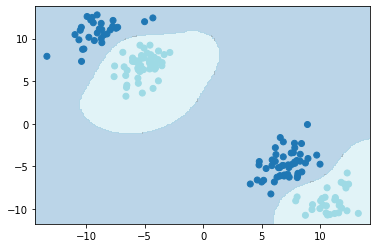

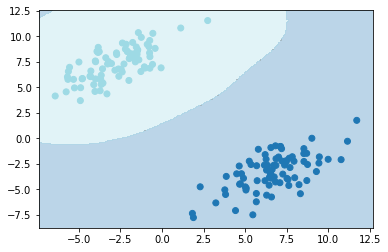

In [13]:
#!/usr/bin/env python3
def example(num_samples=100, num_features=2, grid_size=200, filename="svm.pdf"):
    Data_obj = Data();
    Plot_obj = Plotting();    
    
    X_1, y_1, X_2, y_2 = Data_obj.gen_non_lin_separable_data(seed=1)
    clf = SVM(kernel=Kernel.rbf(0.1),kernel_type = 'gaussian', C=100, gamma=0.001, degree=5)  
    #Split dataset into training and testing samples                                           
    X_train, y_train, X_test, y_test = Data.split_data(X_1, y_1, X_2, y_2,0.8) 
    clf.fit(X_train, y_train)
    Plot_obj.plot_margin(X_train, y_train, clf);

    X_1, y_1, X_2, y_2 = Data_obj.gen_lin_separable_overlap_data(seed=3)
    clf = SVM(kernel=Kernel.rbf(0.1),kernel_type = 'polynomial', C=100, gamma=0.001, degree=3)  
    #Split dataset into training and testing samples                                           
    X_train, y_train, X_test, y_test = Data.split_data(X_1, y_1, X_2, y_2,0.8) 
    clf.fit(X_train, y_train)
    Plot_obj.plot_margin(X_train, y_train, clf);
 


if __name__ == "__main__":
    example()
  